# MIOFlow to infer trajectories on PHATE space

Prerequisites:
- You have preprocessed your data and saved a mioflow DataFrame [notebook: 3-time-pseudotime]: 
    - rows are cells
    - columns are embeddings dimensions
    - "samples" are the discrete time labels


In this notebook, we will:
- Run MIOFlow on our PHATE space to infer trajectories

## 1. Importing MIOFlow and defining data paths

In [1]:
from MIOFlow.utils import generate_steps, set_seeds, config_criterion
from MIOFlow.models import make_model, Autoencoder
from MIOFlow.plots import plot_comparision, plot_losses
from MIOFlow.train import train_ae, training_regimen

from MIOFlow.geo import setup_distance
from MIOFlow.exp import setup_exp
from MIOFlow.eval import generate_plot_data

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
PROCESSED_DATA_DIR = os.path.join('../../data', 'processed')
DIMENSION_CHANGER_DIR = os.path.join('../../dimension_changer')
RESULTS_DIR = os.path.join('../../results')

data_name = 'scRNAseq'
SAVE_PATH = os.path.join(RESULTS_DIR, data_name)


## 1. Retrieve the data and embedding normalization
First we retrieve the data.

Then, we will normalize the embeddings as a standard procedure to enable our network to learn better.

**Attention:** It is important to save the _std_ and _mean_ values. 

It is important to save the _std_ and _mean_ values because when decoding back using the `DimChanger`, we need to ensure that the outputs follow the distributions of the initial embeddings.

In [2]:
data = pd.read_csv(os.path.join(SAVE_PATH,'mioflow_data.csv'))
data.head(1)

d1        d2  samples
0 -0.037337 -0.015149        0

In [3]:
# Get embedding columns dynamically
embed_cols = [col for col in data.columns if col.startswith('d') and col[1:].isdigit()] # Retrieve the columns that start with a d
embedding = data[embed_cols].values
embedding

array([[-3.73371948e-02, -1.51487831e-02],
       [-3.14579511e-02, -2.55200343e-03],
       [-2.48881152e-02,  5.28631561e-03],
       ...,
       [ 2.20330172e-02, -6.18872815e-04],
       [ 2.33663126e-02, -4.81802617e-04],
       [ 1.98009387e-02,  9.76959776e-05]])

### Normalizing the data

In [4]:
# Normalize across all dimensions properly
mean_vals = np.mean(embedding, axis=0)
std_vals = np.std(embedding, axis=0)
std_vals = np.where(std_vals == 0, 1, std_vals)  # Prevent division by zero
normalized = (embedding - mean_vals) / std_vals
# Normalized that is going to be used to train the network
normalized

array([[-2.13138117, -1.29565728],
       [-1.80124669, -0.23987726],
       [-1.43233371,  0.41707958],
       ...,
       [ 1.20240714, -0.07785485],
       [ 1.27727507, -0.06636651],
       [ 1.07707026, -0.01779672]])

In [5]:
# We create the dataframe with the normalized data and the samples
df = pd.DataFrame(normalized, columns=[f'd{i+1}' for i in range(normalized.shape[1])])
df['samples'] = data['samples']
df.head(1)

d1        d2  samples
0 -2.131381 -1.295657        0

In [6]:
# Retrieve the number of samples that are in the less representative class.
min_count = df['samples'].value_counts().min()

### [Optional] We can resample our dataset to take an equal number of samples across the time_labels.


```
    # Retrieve the number of samples that are in the less representative class.
    min_count = df['samples'].value_counts().min()
    # Subsample the dataset to keep the same number of samples across all possible samples
    df = df.groupby('samples').apply(lambda x: x.sample(min_count)).reset_index(drop=True)
```

In [7]:
# # Retrieve the number of samples that are in the less representative class.
# min_count = df['samples'].value_counts().min()
# # Subsample the dataset to keep the same number of samples across all possible samples
# df = df.groupby('samples').apply(lambda x: x.sample(min_count)).reset_index(drop=True)

### Let's visualize what will be our input data using PHATE

If your data looks right, and we can see a path for the trajectories to follow, we can move on to training the MIOFlow algorithm

<Axes: xlabel='d1', ylabel='d2'>

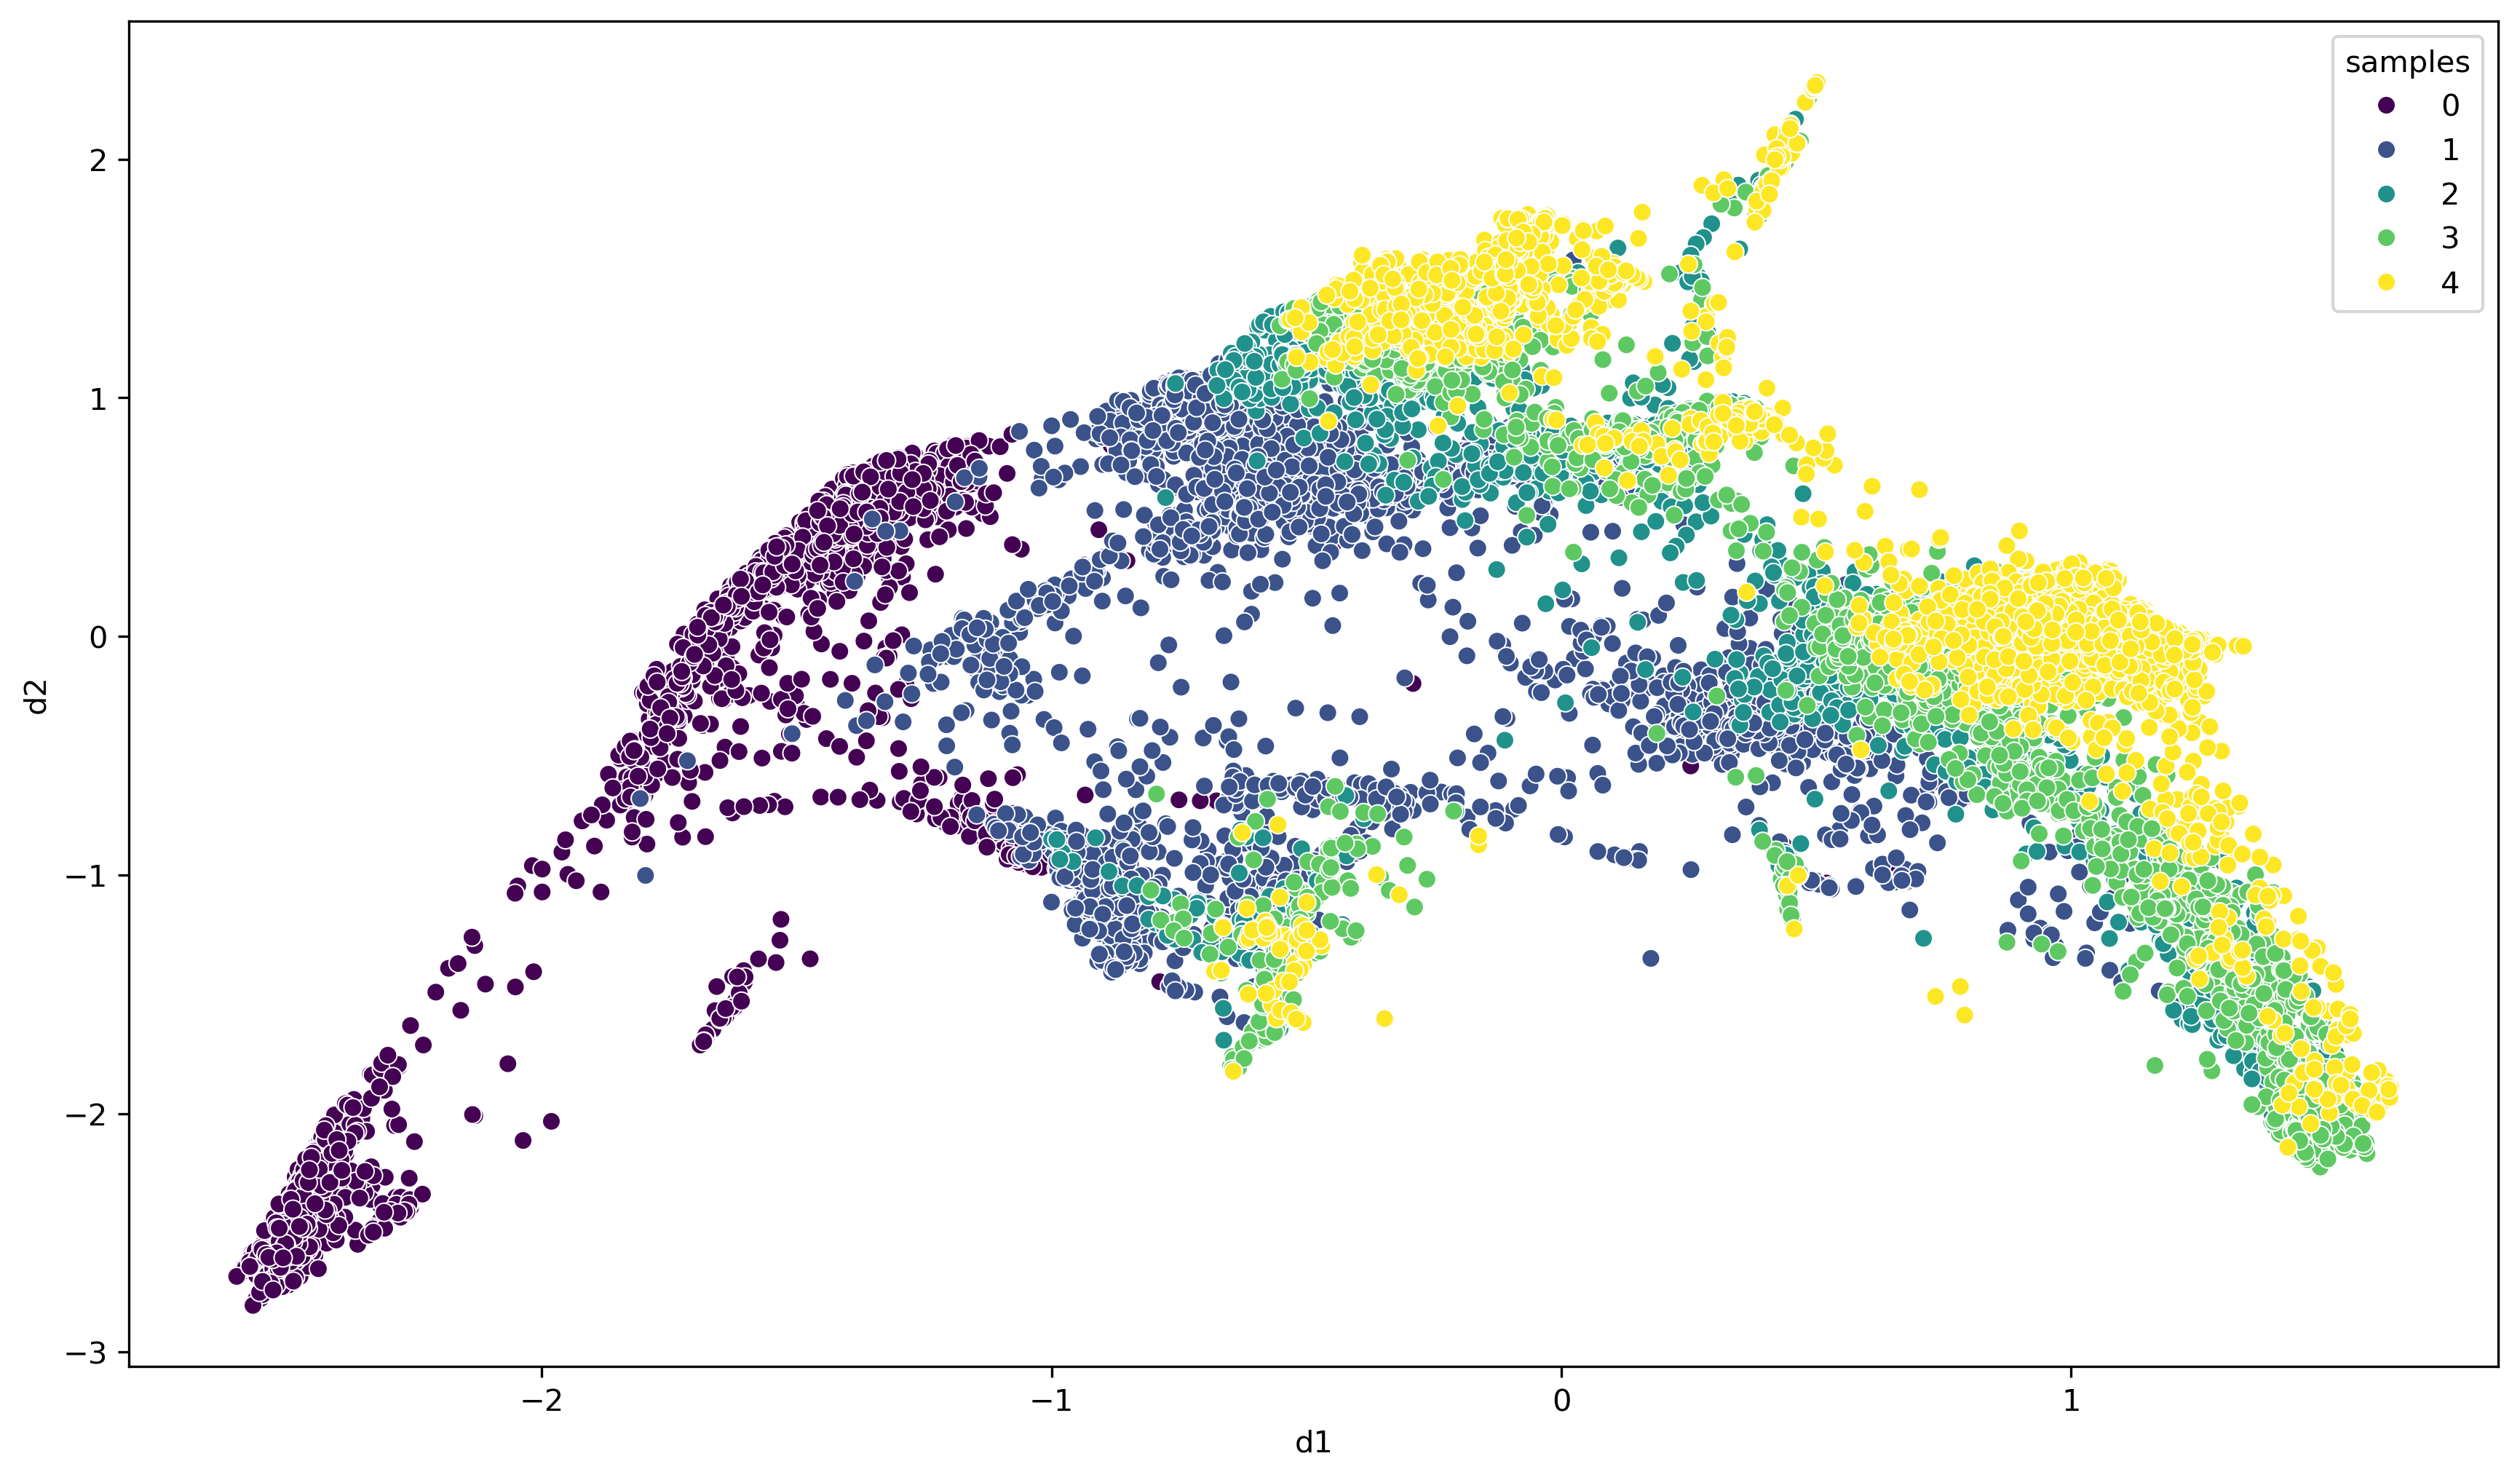

In [8]:
fig = plt.figure(figsize=(14, 8), dpi=300)
sns.scatterplot(data=df, x='d1', y='d2', hue='samples', palette='viridis')

# Training the MIOFlow Model

A lot of this initial cells will be just setting up configurations to run the MIOFlow algorithm.

In [82]:
import torch
set_seeds(0)
use_cuda = torch.cuda.is_available()

In [84]:
# Here we create the model using the MIOFlow library

model = make_model(
    feature_dims = (len(df.columns) - 1),# The dimensions in the input space, it is columns - 1 because we assume one column is equal to "samples"., 
    layers = [16,32,16], # Can change but we never really do, mostly depends on the dataset.
    activation='CELU',
    scales=None, #sde_scales
    use_cuda=use_cuda
)


# Bookkeeping variables
batch_losses = []
globe_losses = []
local_losses = []

start_time = time.time()
local_losses, batch_losses, globe_losses = training_regimen(

    # local, global, local train structure
    n_local_epochs=40, 
    n_epochs=40, 
    n_post_local_epochs=0,
    
    # where results are stored
    exp_dir=SAVE_PATH, 

    # BEGIN: train params
    model=model, 
    df=df, 
    groups=sorted(df.samples.unique()), # Sorted list of the samples (the time bins)


    optimizer=torch.optim.AdamW(model.parameters()), 
    criterion=config_criterion('ot'), 
    use_cuda=use_cuda,

    hold_one_out=False, # True if we want to holdout (or skip) one timepoint during training. Can test the accuracy of the trajectories on unseen data.

    use_density_loss=True, # Density loss knn
    lambda_density=20,# Weight of density (not percentage of total loss)

    autoencoder=None, use_emb=False, use_gae=False, # This are used only if we are going to use the GeodesicAutoencoder (not in single-cell data)
    sample_size=(min(min_count, 100), ), # Basically "batch size"
    logger=None,

    reverse_schema=True,  # Using the reverse trajectories to train
    reverse_n=2,
    # END: train params

    plot_every=5,

    n_points=min(min_count, 100), # use 100 "batch_size" or if have lessa samples, reduce the batch size
    n_trajectories=min(min_count, 100), # use 100 "batch_size" or if have lessa samples, reduce the batch size
    n_bins=100 # TODO: define

)
run_time = time.time() - start_time

Pretraining Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.72925


/Users/joaofelipe/miniconda3/envs/omics_toolbox/lib/python3.10/site-packages/MIOFlow/plots.py:229: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(frameon=False)


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.80008


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.67175


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.55459


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.18844


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.16115


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.73802


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.25591


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.32732


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.09495


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.10284


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.31749


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.89766


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.32051


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.76505


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.30617


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.71298


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.24778


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.60133


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.28366


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.6479


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.32167


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.48363


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.17604


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.42274


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.46336


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.32113


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.19338


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.33033


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.35203


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.29344


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.37507


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.20323


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.26622


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.21234


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.08539


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.1277


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.32391


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.26625


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 4.28073


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.14067


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.51335


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 9.70043


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.09822


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 8.02656


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.54641


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.81816


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.3906


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.5333


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.27898


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.02531


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.11086


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.42083


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.09365


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.50389


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.868


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.48519


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.67495


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.10393


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.78068


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.38648


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.66234


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.52154


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.60391


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.79741


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.35869


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.29008


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.27842


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.28313


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.13983


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.39227


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.10224


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.51823


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.48999


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 7.18187


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.14273


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.83298


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 5.94178


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.86902


  0%|          | 0/20 [00:00<?, ?it/s]

Train loss: 6.26816


Posttraining Epoch: 0it [00:00, ?it/s]

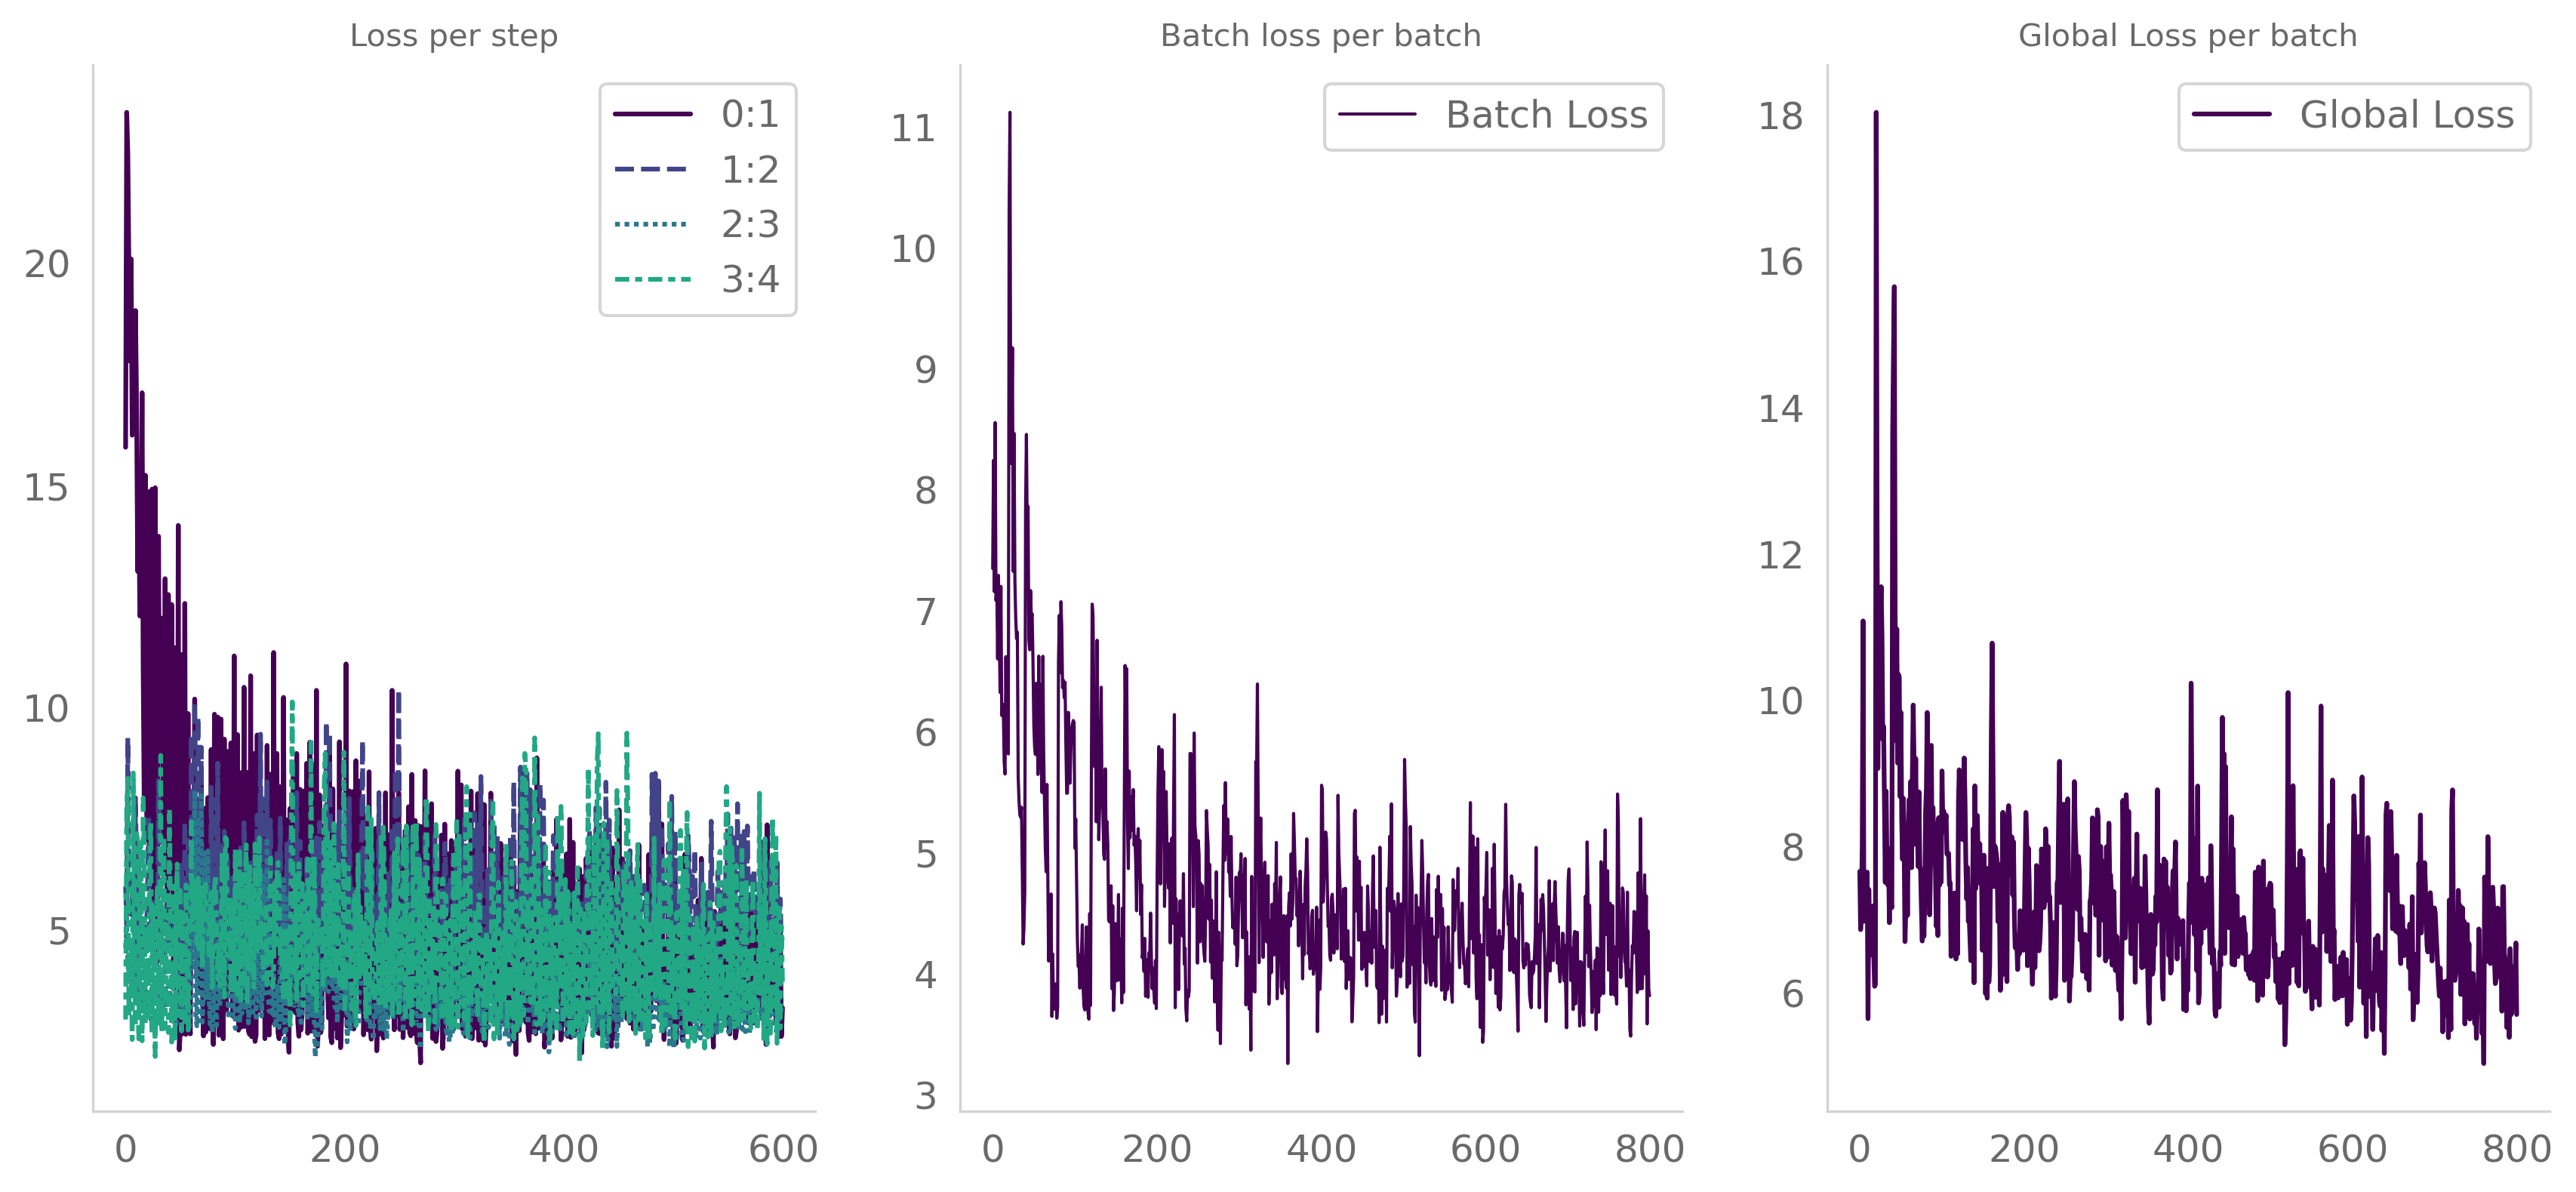

In [85]:
plot_losses(
    local_losses, 
    batch_losses, 
    globe_losses, 
    save=True, 
    path=SAVE_PATH, 
    file='losses.png'
)

In [86]:
generated, trajectoriespts = generate_plot_data(
    model, 
    df, 
    n_points=100, 
    n_trajectories=100, 
    n_bins=100, 
    use_cuda=use_cuda, 
    samples_key='samples', 
    logger=None,
    autoencoder=None, 
    recon=None
)

## Visualizing the MIOFlow Outputs and saving

In [87]:
trajectoriespts = trajectoriespts * std_vals + mean_vals
generated = generated * std_vals + mean_vals
true_data = df[[f'd{i}' for i in range(1, len(df.columns))]] * std_vals + mean_vals

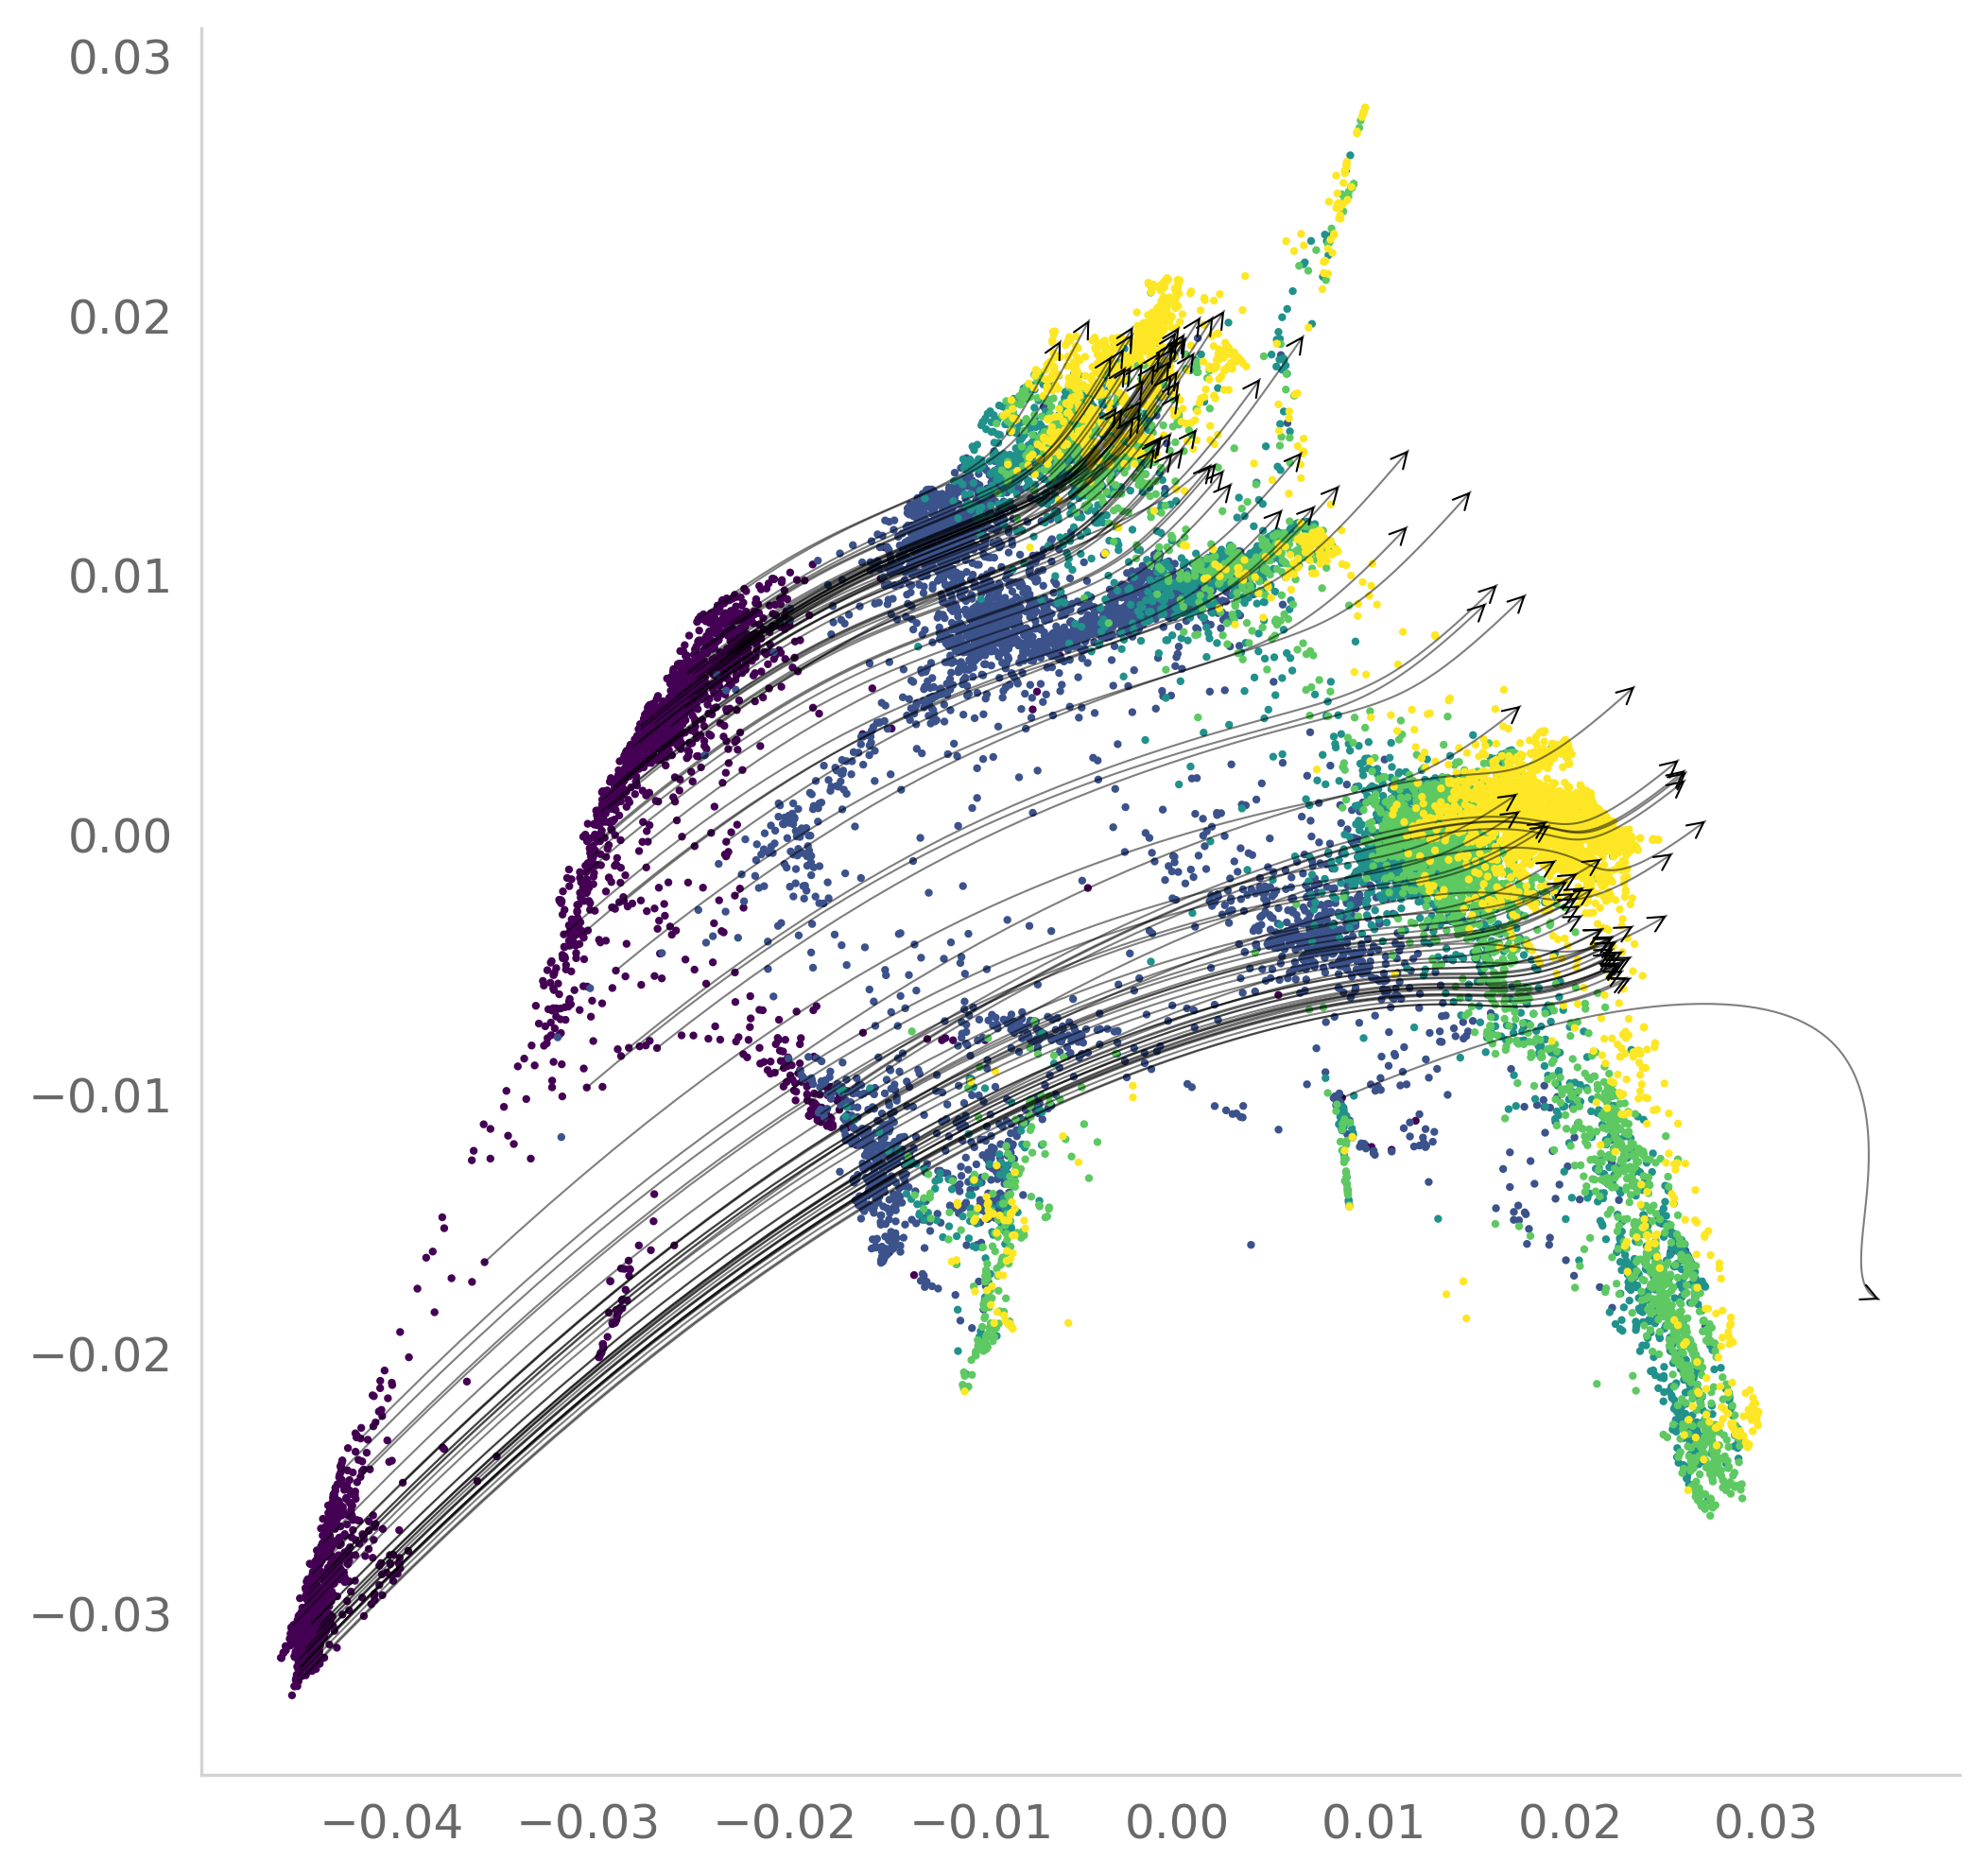

In [ ]:
fig = plt.figure(figsize=(8, 8), dpi=300)
plt.scatter(true_data.values[:, 0], true_data.values[:, 1], c=df['samples'].values, cmap='viridis', s=1)
for i,traj in enumerate(np.transpose(trajectoriespts, axes=(1,0,2))):
    # widths = m_traj[:,i]
    plt.plot(traj[:, 0], traj[:, 1], alpha=.5, linewidth=.5, color='Black')
    plt.annotate('', xy=(traj[-1, 0], traj[-1, 1]), xytext=(traj[-2, 0], traj[-2, 1]),
                 arrowprops=dict(arrowstyle='->', color='Black', lw=.5, mutation_scale=10))

### Since our trajectorie are looking good we can save them and let's visualize and interpret some of them in the next notebooks!

In [90]:
# saving the trajectories and generated points
# trajectories are the outputs for MIOFLow

np.save(os.path.join(SAVE_PATH,'trajectories.npy'), trajectoriespts)
np.save(os.path.join(SAVE_PATH,'generated.npy'), generated)
np.savez(os.path.join(SAVE_PATH, 'normalize.npz'), mean=mean_vals, std=std_vals)

#Pandas saving
true_data.to_csv(os.path.join(SAVE_PATH,'true_data.csv'))
df['samples'].to_csv(os.path.join(SAVE_PATH,'df_samples.csv'))

torch.save(model, SAVE_PATH + '/model.pt')
